In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 1. Load MNIST Fashion dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.63MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.1MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# 2. Define CAM Architecture
class CAM_Model(nn.Module):
    def __init__(self, num_classes=10):
        super(CAM_Model, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)  # GAP Layer
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        feature_maps = self.conv(x)  # Feature maps
        x = self.pool(feature_maps)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out, feature_maps

model = CAM_Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 3. Train the Model
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

Epoch [1/5], Loss: 2.0624
Epoch [2/5], Loss: 2.0051
Epoch [3/5], Loss: 2.0035
Epoch [4/5], Loss: 2.0030
Epoch [5/5], Loss: 2.0015


In [ ]:
# 4. Test and Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

evaluate_model(model, test_loader)

Accuracy: 24.64%


In [ ]:
# 5. Generate CAM for Sample Images
def generate_CAM(model, image, label):
    model.eval()
    output, feature_maps = model(image.unsqueeze(0))
    weight_softmax = model.fc.weight[label]
    cam = torch.sum(weight_softmax.unsqueeze(1).unsqueeze(2) * feature_maps.squeeze(0), dim=0)
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()
    return cam.detach().numpy()

In [ ]:
# 6. Display CAM for Correct and Incorrect Predictions
def display_CAM(model, test_loader, num_correct=10, num_incorrect=10):
    correct_shown, incorrect_shown = 0, 0
    for images, labels in test_loader:
        outputs, _ = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(images)):
            if correct_shown < num_correct and predicted[i] == labels[i]:
                cam = generate_CAM(model, images[i], predicted[i])
                plt.figure(figsize=(3,3))
                plt.imshow(images[i][0], cmap='gray')
                plt.imshow(cam, cmap='jet', alpha=0.5)
                plt.title(f"Correct: {labels[i]}")
                plt.show()
                correct_shown += 1
            elif incorrect_shown < num_incorrect and predicted[i] != labels[i]:
                cam = generate_CAM(model, images[i], predicted[i])
                plt.figure(figsize=(3,3))
                plt.imshow(images[i][0], cmap='gray')
                plt.imshow(cam, cmap='jet', alpha=0.5)
                plt.title(f"Incorrect: Pred={predicted[i]}, Actual={labels[i]}")
                plt.show()
                incorrect_shown += 1
            if correct_shown >= num_correct and incorrect_shown >= num_incorrect:
                return

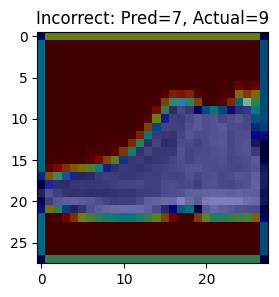

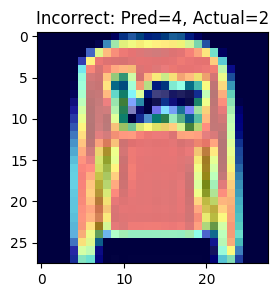

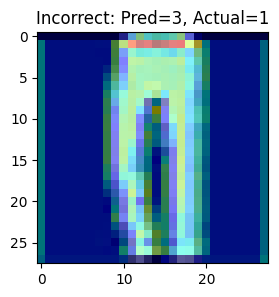

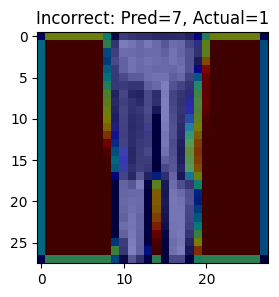

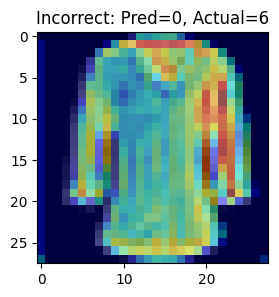

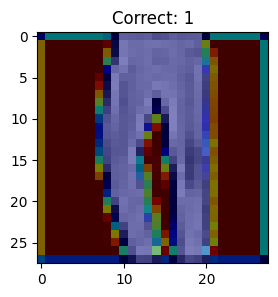

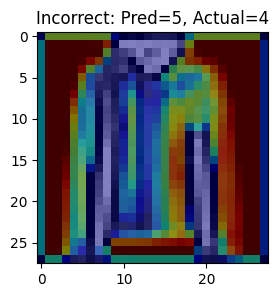

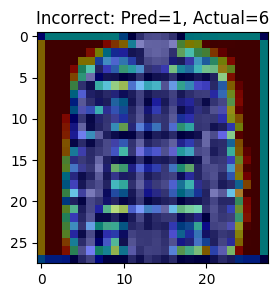

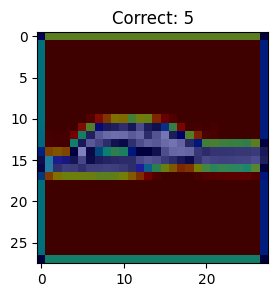

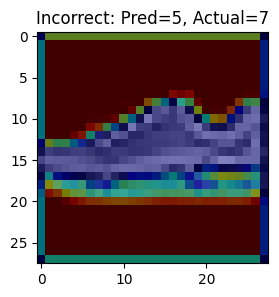

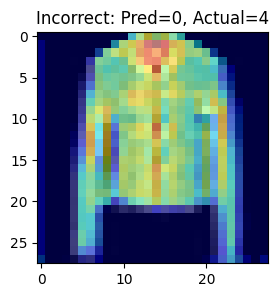

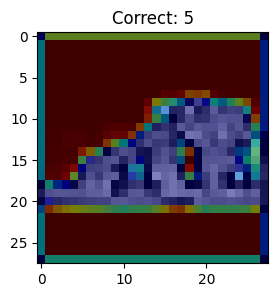

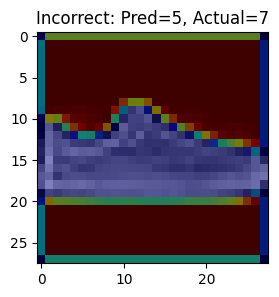

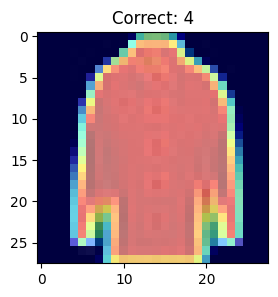

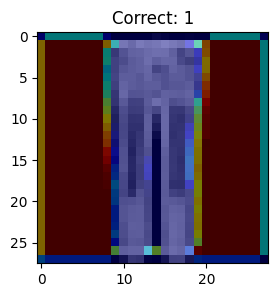

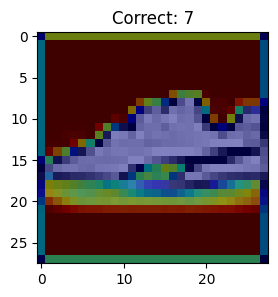

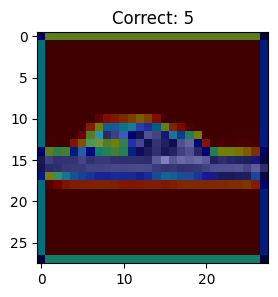

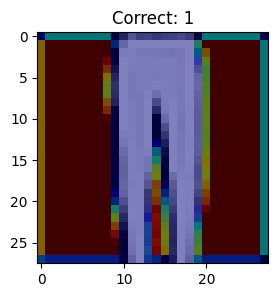

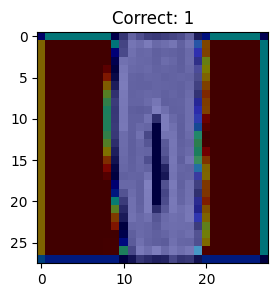

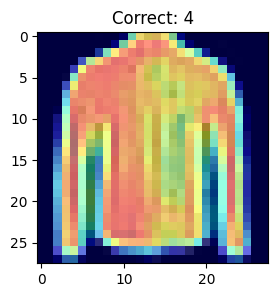

In [ ]:
# Display CAMs
display_CAM(model, test_loader)